# CBB Ranking Adjusted by 3 pt Shooting

This is the general outline for this ranking:

* One parameter per team tracking the following quantities:
  * Adjusted offensive efficiency
  * Adjusted defensive efficiency
  * 3 point shooting percentage
  * Tempo
* Inputs
  * Raw offensive efficiency
  * Raw defensive efficiency
  * 3 point shots taken and made
* General structure of the code
  * Set team-length vectors `oeff`, `deff`, `3pct`, and `tempo`
  * Data views each game from POV of winning team
  * Iterate through each game, creating a new `adj_oeff` and `adj_deff` that is a "what if" based on that team shooting their average from three. These "what-ifs" use the `3pct` vectors.
  * Iterate through each game again, modeling the `adj_oeff` and `adj_deff`  based on the `oeff`, `deff`, and an error term.
  * Model 3pm given 3pa as a binomial using `3pct`


In [1]:
import pandas as pd 
import numpy as np
import pystan
import matplotlib.pyplot as plt
import arviz
import seaborn as sns

from pyprojroot import here

In [5]:
games = pd.read_csv(here("data/acc_games_2018.csv"), parse_dates=['date_game'])
teams = pd.read_csv(here("data/ncaa_teams_all.csv"))
games.head()

,efficiency_i,efficiency_j,fg3_i,fg3_j,fg3a_i,fg3a_j,home_i,date_game,year,avg_possessions,game_id,gos_i,gos_j,team_i,team_j
0,1.184141,1.117616,15.0,8.0,26.0,30.0,1,2017-12-09,2018,75.16,41590,9.0,11.0,782,837
1,0.946119,0.930083,9.0,7.0,23.0,22.0,1,2017-12-30,2018,62.36,41594,12.0,13.0,1086,782
2,1.069055,1.011268,8.0,9.0,23.0,21.0,-1,2018-01-03,2018,69.22,41595,13.0,14.0,815,782
3,0.974684,0.898734,7.0,12.0,22.0,26.0,1,2018-01-06,2018,79.00,41596,15.0,14.0,782,1091
4,1.425601,0.980101,9.0,12.0,27.0,33.0,1,2018-01-09,2018,67.34,41597,16.0,16.0,966,782


In [6]:
cutoff = pd.to_datetime("2018-02-15")
train = games[games['date_game'] < cutoff]
test = games[games['date_game'] >= cutoff]
print(train.shape)
print(test.shape)

(100, 15)
(50, 15)


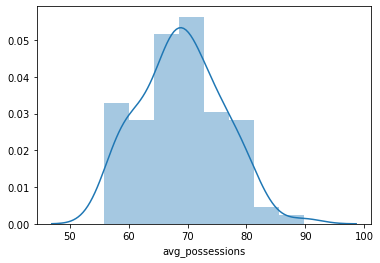

In [10]:
sns.distplot(train['avg_possessions'])
# sns.distplot(train['efficiency_j'])

In [ ]:


model_code = """
data {
    int<lower=0> k;
    int<lower=0> n;
    int h[n];
    int team_i[n];
    int team_j[n];
    vector[n] diff;
    
    int<lower=0> n_test;
    int h_test[n_test];
    int team_i_test[n_test];
    int team_j_test[n_test];
}
transformed data {}
parameters {
    vector[k] theta_raw;
    real<lower=0> eta;
    real<lower=0> sigma;
    real<lower=0> tau_theta;
}
transformed parameters {
    vector[k] theta;
    theta = theta_raw * tau_theta;
}
model {
    vector[n] mu;
    eta ~ normal(4, 1);
    sigma ~ cauchy(0, 1)T[0,];
    tau_theta ~ cauchy(0, 1)T[0,];
    theta_raw ~ normal(0, 1);

    for (i in 1:n) {
        mu[i] = theta[team_i[i]] - theta[team_j[i]] + eta * h[i];
        //diff[i] ~ normal(theta[team_i[n]] - theta[team_j[n]] + eta * h[n], sigma);
    }
    
    diff ~ normal(mu, sigma);
}
generated quantities {
    vector[n_test] mu_test;
    vector[n_test] diff_test;

    for (i in 1:n_test) {
        mu_test[i] = theta[team_i_test[i]] - theta[team_j_test[i]] + eta * h_test[i];
        diff_test[i] = normal_rng(mu_test[i], sigma);
    }
}
"""
dat = {
    'k': len(np.union1d(train['team_i'].unique(), train['team_j'].unique())),
    'n': len(train),
    'h': train['home_i'],
    'team_i': train['team_i'],
    'team_j': train['team_j'],
    'diff': train['score_i'] - train['score_j'],
    'n_test': len(test),
    'h_test': test['home_i'],
    'team_i_test': test['team_i'],
    'team_j_test': test['team_j']
}

sm = pystan.StanModel(model_code=model_code)
print('fitting model')
fit = sm.sampling(data=dat, warmup=500, iter=2500, chains=2, refresh=100)


In [11]:
model_code = """
data {
    // train values
    int<lower=0> k;
    int<lower=0> n;
    int h[n];
    int team_i[n];
    int team_j[n];
    vector[n] raw_eff_i;
    vector[n] raw_eff_j;
    vector[n] possessions;
    
    // test values
    int<lower=0> n_test;
    int h_test[n_test];
    int team_i_test[n_test];
    int team_j_test[n_test];    
}
parameters {
    vector[k] oeff;
    vector[k] deff;
    vector[k] tempo;
    real<lower=0> sigma;
    real<lower=0> tau_eff;
    real<lower=0> sigma_tempo;    
    real<lower=0> tau_tempo;    
}
transformed parameters {

}
model {
    // variances
    sigma ~ cauchy(0, 0.25);
    tau_eff ~ cauchy(0, 0.25);
    sigma_tempo ~ cauchy(0, 5);
    tau_tempo ~ cauchy(0, 5);

    // Team specific parameters
    oeff ~ normal(1, tau_eff);
    deff ~ normal(1, tau_eff);
    tempo ~ normal(70, tau_tempo);

    // Model data
    for (t in 1:n) {
        raw_eff_i[t] ~ normal((oeff[team_i[t]] + deff[team_j[t]]) / 2, sigma);
        raw_eff_j[t] ~ normal((oeff[team_j[t]] + deff[team_i[t]]) / 2, sigma);
        possessions[t] ~ normal((tempo[team_i[t]] + tempo[team_j[t]]) / 2, sigma_tempo);
    }
}
generated quantities {
    // Declare vectors
    vector[n_test] scores_i;
    vector[n_test] scores_j;
    vector[n_test] test_possessions;

    // Simulate games
    for (t in 1:n_test) {
        test_possessions[t] = normal_rng((tempo[team_i_test[t]] + tempo[team_j_test[t]]) / 2, sigma_tempo);
        scores_i[t] = test_possessions[t] * normal_rng((oeff[team_i_test[t]] + deff[team_j_test[t]]) / 2, sigma);
        scores_j[t] = test_possessions[t] * normal_rng((oeff[team_j_test[t]] + deff[team_i_test[t]]) / 2, sigma);
    }
}
"""
dat = {
    'k': len(np.union1d(train['team_i'].unique(), train['team_j'].unique())),
    'n': len(train),
    'h': train['home_i'],
    'team_i': train['team_i'],
    'team_j': train['team_j'],
    'raw_eff_i': train['efficiency_i'],
    'raw_eff_j': train['efficiency_j'],
    'possessions': train['avg_possessions'],
    'n_test': len(test),
    'h_test': test['home_i'],
    'team_i_test': test['team_i'],
    'team_j_test': test['team_j']
}

sm = pystan.StanModel(model_code=model_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6be6a3c84e829d79b25adb72813ddaa NOW.


In [12]:
fit = sm.sampling(data=dat, warmup=500, iter=2500, chains=2, refresh=100)


RuntimeError: Exception: []: accessing element out of range. index 782 out of range; expecting index to be between 1 and 15; index position = 1oeff  (in 'unknown file name' at line 45)
